<a href="https://colab.research.google.com/github/PedroTricossi/Analise-de-dados/blob/master/Classifica%C3%A7%C3%A3o_cachorro_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modelo de classificação utilizando CNN para diferenciação de cães e gatos**

### Importação das bibliotecas que serão utilizadas

In [0]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Download do dataset que será utilizado no projeto

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


### Direcionando os cada parte do projeto a seus respectivos diretórios 

In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
#direcionando a parte de treino e de validação para diretorios diferentes
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  

In [0]:
#pegando o tamanho dos diretorios e somando
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('Total de imagens de gato para treino:', num_cats_tr)
print('total de imagens de cachorro para treino:', num_dogs_tr)

print('total de imagens de gato para a validação:', num_cats_val)
print('total de imagens de cachorro para a validação:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total de imagens de gato para treino: 1000
total de imagens de cachorro para treino: 1000
total de imagens de gato para a validação: 500
total de imagens de cachorro para a validação: 500
--
Total training images: 2000
Total validation images: 1000


### Limpeza dos dados utilizados no projeto

In [0]:
#Tamanho dos "Grupos" de imagens que serão usados nos treinos
BATCH_SIZE = 100
#Tamanho das imagens 150X150
IMG_SHAPE  = 150

In [0]:
#Função que imprime as imagens
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [10]:
#Como o Dataset utilizado possui poucas imagens, vamos usar uma tecnica de girar, inverter e dar zoom nas imagens para ampliar
#a quantidade de imagens para treino
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


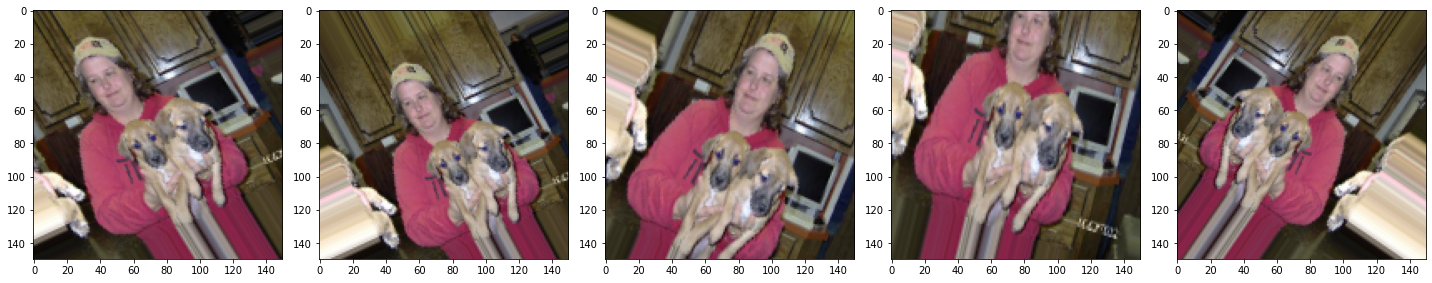

In [11]:
#Exemplo das imagens
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
#Criando uma parte do set de treino para validar o quão bem a CNN está identificando
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### criação do modelo a ser utilizado

In [0]:
#Definição do formato da rede neural
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
#compilação do modelo, escolhendo o otimizador e a função de custo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Treinamento do modelo

In [16]:
#treinamento do modelo
epochs=80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
20/20 [==============================] - 18s 889ms/step - loss: 0.7356 - accuracy: 0.4915 - val_loss: 0.6877 - val_accuracy: 0.5040
Epoch 2/80
20/20 [==============================] - 18s 897ms/step - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5030
Epoch 3/80
20/20 [==============================] - 18s 905ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6882 - val_accuracy: 0.4940
Epoch 4/80
20/20 [==============================] - 18s 905ms/step - loss: 0.6860 - accuracy: 0.5335 - val_loss: 0.6766 - val_accuracy: 0.6110
Epoch 5/80
20/20 [==============================] - 18s 904ms/step - loss: 0.6764 - accuracy: 0.5900 - val_loss: 0.6432 - val_accuracy: 0.6220
Epoch 6/80
20/20 [==============================] - 18s 909ms/step - loss: 0.6646 - accuracy: 0.5940 - val_loss: 0.6568 - val_accuracy: 0.5910
Epoch 7/80
20/20 [==============================] - 18s 909ms/step

### Avaliação do modelo

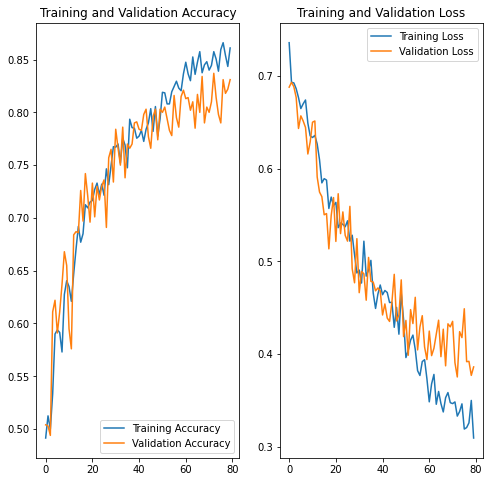

In [17]:
#plot da função custo X precisão
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
#Avaliação com imagens nunca antes vistas pela rede.
est_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/100))
print('Accuracy on test dataset:', test_accuracy)

NameError: ignored